In [ ]:
!pip install dask[dataframe]

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib
from sklearn.utils import resample
from sklearn.manifold import TSNE

In [ ]:
data = pd.read_csv("/content/claude_5k.csv")
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,action
0,1.0,183.19000,8.0,25.0,0.0,1.0,194.19473,4.0,21.000237,0.0,...,265.84274,4.0,23.942608,0.0,1.0,276.03580,12.0,21.653471,0.0,1
1,1.0,183.19193,4.0,25.0,0.0,1.0,193.33936,12.0,22.372660,0.0,...,268.07233,8.0,21.526155,0.0,1.0,278.74005,12.0,21.072702,0.0,4
2,1.0,179.14096,0.0,25.0,0.0,1.0,189.85901,0.0,21.343817,0.0,...,261.67822,4.0,22.992239,0.0,1.0,272.70175,0.0,21.753092,0.0,4
3,1.0,181.36730,12.0,25.0,0.0,1.0,191.84212,12.0,23.029377,0.0,...,265.86804,4.0,22.388924,0.0,1.0,277.21878,0.0,22.246387,0.0,4
4,1.0,182.26968,0.0,25.0,0.0,1.0,193.87680,0.0,23.046627,0.0,...,267.40980,12.0,21.269062,0.0,1.0,279.17953,4.0,23.429052,0.0,4


Removing constant features

In [ ]:
# Identify columns where all values are 1
constant_columns = [col for col in data.columns if data[col].nunique() == 1 and data[col].iloc[0] == 1]

# Remove these columns from the dataframe
data_cleaned = data.drop(columns=constant_columns)
#data_cleaned.reset_index(drop=True, inplace=True)

# Display the updated dataframe without constant columns
print("\nColumns removed (constant columns):", constant_columns)
print("\nDataFrame after removing constant columns:")
data_cleaned.head(5)


Columns removed (constant columns): ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45']

DataFrame after removing constant columns:


,1,2,3,4,6,7,8,9,11,12,...,39,41,42,43,44,46,47,48,49,action
0,183.19000,8.0,25.0,0.0,194.19473,4.0,21.000237,0.0,204.98465,12.0,...,0.0,265.84274,4.0,23.942608,0.0,276.03580,12.0,21.653471,0.0,1
1,183.19193,4.0,25.0,0.0,193.33936,12.0,22.372660,0.0,205.07791,12.0,...,0.0,268.07233,8.0,21.526155,0.0,278.74005,12.0,21.072702,0.0,4
2,179.14096,0.0,25.0,0.0,189.85901,0.0,21.343817,0.0,200.20409,4.0,...,0.0,261.67822,4.0,22.992239,0.0,272.70175,0.0,21.753092,0.0,4
3,181.36730,12.0,25.0,0.0,191.84212,12.0,23.029377,0.0,203.38297,0.0,...,0.0,265.86804,4.0,22.388924,0.0,277.21878,0.0,22.246387,0.0,4
4,182.26968,0.0,25.0,0.0,193.87680,0.0,23.046627,0.0,204.48961,12.0,...,0.0,267.40980,12.0,21.269062,0.0,279.17953,4.0,23.429052,0.0,4


In [ ]:
y = data_cleaned['action']

# Extract the features by dropping the target column ('action')
X = data_cleaned.drop('action', axis=1)  # axis=1 to drop a column

TSNE FOR VERIFICATION

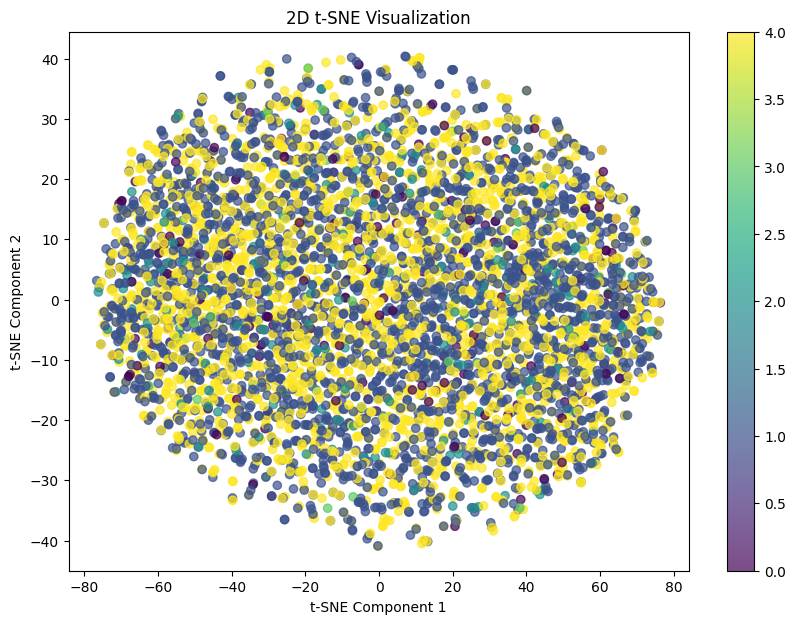

In [ ]:
# Standardize the features (recommended for t-SNE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plotting the t-SNE results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title("2D t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

features that do not effectively capture the differences between classes.

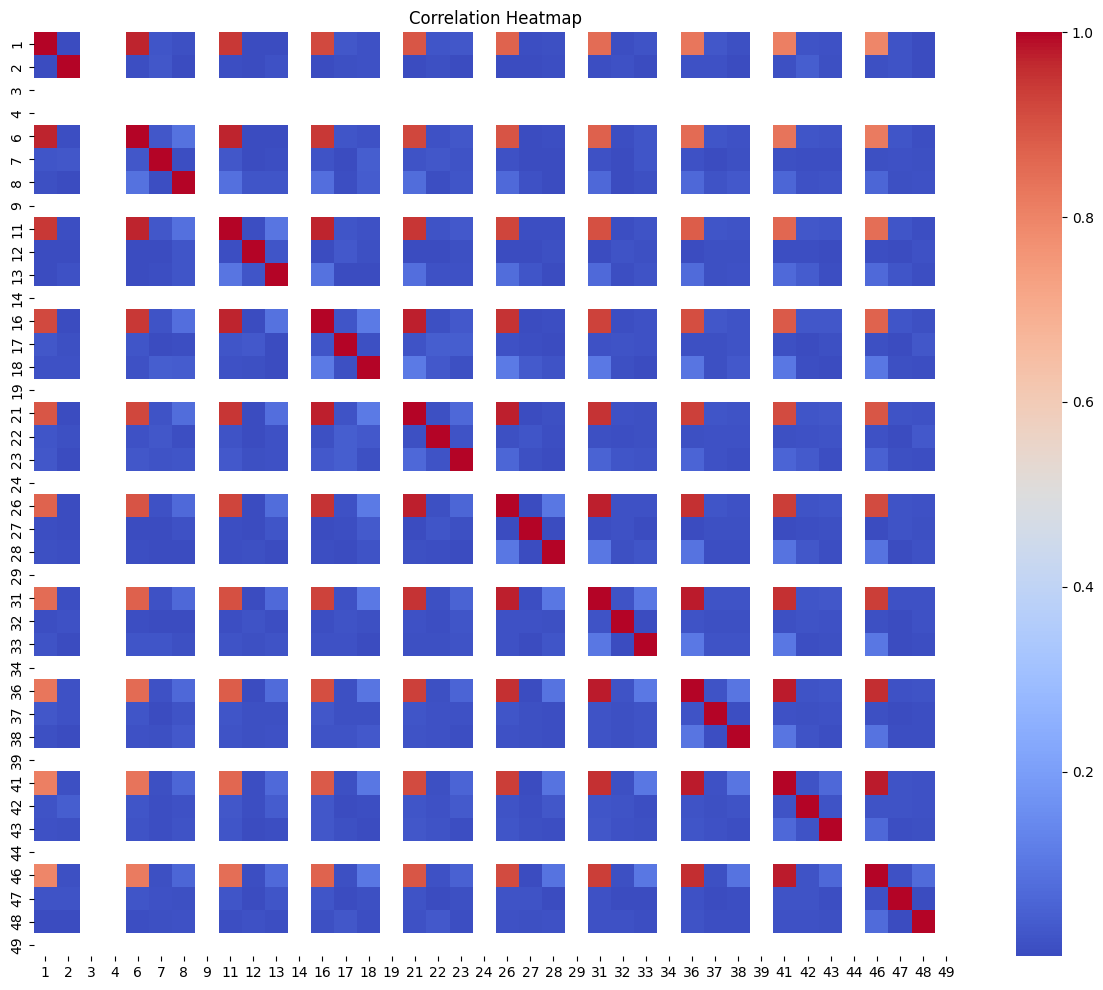

In [ ]:
'''# Computing the correlation matrix
corr_matrix = X.corr()
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(abs(corr_matrix), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()'''

# Computing the correlation matrix
corr_matrix = X.corr()

# Adjusting the figsize to fit the heatmap without whitespace
plt.figure(figsize=(15, 12))  # Increase size to fit all columns
sns.heatmap(abs(corr_matrix), annot=False, cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Heatmap")
plt.show()

try random forest on original data

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode target labels if they are categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (optional, but recommended for many classifiers)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.566
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.58      0.76      0.66       489
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00         5
           4       0.54      0.46      0.50       424

    accuracy                           0.57      1000
   macro avg       0.22      0.24      0.23      1000
weighted avg       0.51      0.57      0.53      1000

Confusion Matrix:
 [[  0  13   0   0  25]
 [  0 372   0   0 117]
 [  0  25   0   0  19]
 [  0   4   0   0   1]
 [  0 230   0   0 194]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def label_hist(y):
  plt.figure(figsize=(10, 6))
  plt.hist(y, bins=5, color='blue', alpha=0.7, edgecolor='black')
  plt.title('Histogram of Labels')
  plt.xlabel('Labels')
  plt.ylabel('Frequency')
  plt.xticks(np.unique(y))  # Ensure all unique labels are shown on the x-axis
  plt.grid(axis='y', alpha=0.75)
  plt.show()

case 1 downsampling majority class

In [ ]:
classes_to_downsample = [1, 4]
n_samples = 1000  # Replace with the desired number of samples

# Separate the classes to downsample
df_class_1 = data[data['action'] == 1]
df_class_4 = data[data['action'] == 4]

# Downsample class 1
df_class_1_downsampled = resample(df_class_1,
                                  replace=False,
                                  n_samples=n_samples,
                                  random_state=42)

# Downsample class 4
df_class_4_downsampled = resample(df_class_4,
                                  replace=False,
                                  n_samples=n_samples,
                                  random_state=42)

# Remove original classes 1 and 4 from the dataset
df_remaining = data[~data['action'].isin(classes_to_downsample)]

# Concatenate the downsampled classes with the remaining dataset
df_final = pd.concat([df_remaining, df_class_1_downsampled, df_class_4_downsampled])

# Shuffle the final dataset
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
y_down = df_final['action']

# Extract the features by dropping the target column ('action')
X_down = df_final.drop('action', axis=1)  # axis=1 to drop a column

case 2 downsaampling majority and upsampling minority using SMOTE

In [ ]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_down, y_down, test_size=0.2, random_state=42)
# Apply SMOTEN to handle class imbalance
# smote = SMOTENC(['2_0.0', '2_4.0',
#        '2_8.0', '2_12.0', '7_0.0', '7_4.0', '7_8.0', '7_12.0', '12_0.0',
#        '12_4.0', '12_8.0', '12_12.0', '17_0.0', '17_4.0', '17_8.0', '17_12.0',
#        '22_0.0', '22_4.0', '22_8.0', '22_12.0', '27_0.0', '27_4.0', '27_8.0',
#        '27_12.0', '32_0.0', '32_4.0', '32_8.0', '32_12.0', '37_0.0', '37_4.0',
#        '37_8.0', '37_12.0', '42_0.0', '42_4.0', '42_8.0', '42_12.0', '47_0.0',
#        '47_4.0', '47_8.0', '47_12.0'], sampling_strategy="auto",
#               k_neighbors=2,
#               random_state=42)

smote = SMOTE(sampling_strategy="auto",
               k_neighbors=2,
               random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)


categorical class,  replaced by 1 hot encoding

In [ ]:
# Identify columns that have exactly 4 unique values
columns_with_4_unique = [col for col in data_cleaned.columns if data_cleaned[col].nunique() == 4 and col!='action']

# Display columns with 4 unique values
print("\nColumns with exactly 4 unique values:")
print(columns_with_4_unique)

# One-hot encode the columns with 4 unique values
df_encoded = pd.get_dummies(data_cleaned, columns=columns_with_4_unique,dtype=int)

# Display the encoded dataframe
print("\nDataFrame after one-hot encoding:")
df_encoded.head()


Columns with exactly 4 unique values:
['2', '7', '12', '17', '22', '27', '32', '37', '42', '47']

DataFrame after one-hot encoding:


,1,3,4,6,8,9,11,13,14,16,...,37_8.0,37_12.0,42_0.0,42_4.0,42_8.0,42_12.0,47_0.0,47_4.0,47_8.0,47_12.0
0,183.19000,25.0,0.0,194.19473,21.000237,0.0,204.98465,23.771336,0.0,215.03693,...,0,1,0,1,0,0,0,0,0,1
1,183.19193,25.0,0.0,193.33936,22.372660,0.0,205.07791,23.945366,0.0,214.59790,...,0,1,0,0,1,0,0,0,0,1
2,179.14096,25.0,0.0,189.85901,21.343817,0.0,200.20409,23.967997,0.0,211.48848,...,0,0,0,1,0,0,1,0,0,0
3,181.36730,25.0,0.0,191.84212,23.029377,0.0,203.38297,23.421846,0.0,212.44893,...,0,0,0,1,0,0,1,0,0,0
4,182.26968,25.0,0.0,193.87680,23.046627,0.0,204.48961,22.147213,0.0,215.17357,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
df_encoded.columns

Index(['1', '3', '4', '6', '8', '9', '11', '13', '14', '16', '18', '19', '21',
       '23', '24', '26', '28', '29', '31', '33', '34', '36', '38', '39', '41',
       '43', '44', '46', '48', '49', 'action', '2_0.0', '2_4.0', '2_8.0',
       '2_12.0', '7_0.0', '7_4.0', '7_8.0', '7_12.0', '12_0.0', '12_4.0',
       '12_8.0', '12_12.0', '17_0.0', '17_4.0', '17_8.0', '17_12.0', '22_0.0',
       '22_4.0', '22_8.0', '22_12.0', '27_0.0', '27_4.0', '27_8.0', '27_12.0',
       '32_0.0', '32_4.0', '32_8.0', '32_12.0', '37_0.0', '37_4.0', '37_8.0',
       '37_12.0', '42_0.0', '42_4.0', '42_8.0', '42_12.0', '47_0.0', '47_4.0',
       '47_8.0', '47_12.0'],
      dtype='object')

class weights if neccessary

In [ ]:
X = df_encoded.drop(columns=['action'])
y = df_encoded['action']
class_mapping = {0: 0, 1: 1, 2: 2,4:3}
y = y.map(class_mapping)

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.98)  # Retain 99% of variance
X_res_pca = pca.fit_transform(X_res_scaled)
X_test_pca = pca.transform(X_test_scaled)



Random Forest

In [ ]:
  # Initialize and train the Random Forest model
rf_model = RandomForestClassifier(
bootstrap=False,
max_depth=30,
max_features='sqrt',
min_samples_leaf=1,
min_samples_split=5,
n_estimators=500,
random_state=42, class_weight = "balanced"
)

    # # Define the hyperparameters and their values to be searched
    # param_grid = {
    #     'n_estimators': [100, 500, 1000],  # Number of trees in the forest
    #     'max_depth': [10, 20, 30, None],  # Maximum depth of each tree
    #     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    #     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required in a leaf node
    #     'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
    #     'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
    # }

    # # Apply GridSearchCV to search for the best hyperparameters
    # grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
    #                         cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

    # # Fit the grid search
    # grid_search.fit(X_train, y_train)

    # # View the best hyperparameters
    # print("Best Hyperparameters:", grid_search.best_params_)

    #Predict using the best model

rf_model.fit(X_train, y_train)

# Step 5: Model Evaluation on Test Data
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")

# Classification report
class_report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

Random Forest Model Accuracy: 53.78%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.26      0.34        39
           1       0.59      0.66      0.62       197
           2       0.56      0.08      0.14        62
           3       0.00      0.00      0.00         7
           4       0.49      0.64      0.56       184

    accuracy                           0.54       489
   macro avg       0.43      0.33      0.33       489
weighted avg       0.53      0.54      0.51       489

Confusion Matrix:
 [[ 10   4   0   0  25]
 [  1 130   2   0  64]
 [  0  25   5   0  32]
 [  0   7   0   0   0]
 [  9  55   2   0 118]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

XGB

In [ ]:
# Initialize and fit the XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_res_pca, y_train)
#xgb_model.fit(X_train, y_train)
# Predict on test data
y_pred = xgb_model.predict(X_test_pca)
#y_pred = xgb_model.predict(X_train)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"xgb Model Accuracy: {accuracy * 100:.2f}%")

# Classification report
class_report = classification_report(y_test, y_pred, output_dict=True,zero_division=1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix (optional for further evaluation)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

xgb Model Accuracy: 40.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.23      0.25        39
           1       0.47      0.47      0.47       197
           2       0.17      0.15      0.16        62
           3       0.00      0.00      0.00         7
           4       0.43      0.47      0.45       184

    accuracy                           0.40       489
   macro avg       0.27      0.26      0.26       489
weighted avg       0.39      0.40      0.40       489

Confusion Matrix:
[[ 9 12  0  0 18]
 [ 9 93 20  2 73]
 [ 1 32  9  0 20]
 [ 1  2  0  0  4]
 [14 59 23  2 86]]


CLASS 4 ALMOST CONFUSED WITH EVERY CLASS

In [ ]:
from sklearn.ensemble import VotingClassifier

lgbm = LGBMClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb), ('rf', rf), ('lgbm', lgbm)],

    voting='soft')
voting_clf.fit(X_res_pca, y_train)
y_pred_ensemble = voting_clf.predict(X_test_pca)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4080, number of used features: 20
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X_res_pca, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

Cross-validation scores: [0.71813725 0.77083333 0.76102941 0.79779412 0.78186275]
Mean accuracy: 0.77


In [ ]:
# Confusion matrix (optional for further evaluation)
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[12 12  0  0 15]
 [ 8 99 15  1 74]
 [ 1 31  9  0 21]
 [ 1  2  0  0  4]
 [16 63 18  0 87]]


In [ ]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")
class_report = classification_report(y_test, y_pred_ensemble, output_dict=True,zero_division=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

Ensemble Model Accuracy: 42.33%
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.31      0.31        39
           1       0.48      0.50      0.49       197
           2       0.21      0.15      0.17        62
           3       0.00      0.00      0.00         7
           4       0.43      0.47      0.45       184

    accuracy                           0.42       489
   macro avg       0.29      0.29      0.29       489
weighted avg       0.41      0.42      0.41       489



MLP CLASSIFIER

In [ ]:
from sklearn.neural_network import MLPClassifier
# Create an MLP Classifier with class weights to handle imbalanced classes
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Fit the model
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.29      0.56      0.38        39
           1       0.40      0.19      0.26       197
           2       0.23      0.55      0.32        62
           3       0.04      0.29      0.07         7
           4       0.38      0.25      0.30       184

    accuracy                           0.29       489
   macro avg       0.27      0.37      0.27       489
weighted avg       0.36      0.29      0.29       489



SVC ONE CLASS

In [ ]:
from sklearn.svm import SVC
# Create a Support Vector Classifier with class weights to handle imbalanced classes
svc = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Fit the model
svc.fit(X_train, y_train)

# Make predictions
y_pred = svc.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.79      0.35        39
           1       0.48      0.21      0.29       197
           2       0.20      0.39      0.26        62
           3       0.00      0.00      0.00         7
           4       0.47      0.23      0.31       184

    accuracy                           0.28       489
   macro avg       0.27      0.32      0.24       489
weighted avg       0.41      0.28      0.29       489

